# Abstract

Deep learning models have achieved excellent performance in various domains such as visual and language understanding recently. However, they are vulnerable to different kinds of adversarial attacks. This vulnerability is crucial since many machine learning algorithms are trained on sensitive data (e.g. data for medical diagnosis) and are being used in critical decision-making processes, so it is essential to keep them safe from adversaries who want to access personal data, steal an expensively trained model or poison training dataset. In this tutorial, we will look into evasion and poisoning attacks and mechanisms to defend against them. Before we start, I must say that this is more of an introductory tutorial rather than a comprehensive one, and my goal is to introduce some of the topics in Robust and Trustworthy Machine Learning so you can understand related papers and study more on your own.

# Table of Contents

1. [Terminology](#terminology)

2. [Evasion and Adversarial Training](#evasion)
 - 2.1 [How can we construct adversarial examples?](#2.1)
      - 2.1.1 [Fast Gradient Sign Method (FGSM)](#2.1.1)
      - 2.1.2 [Projected Gradient Descent (PGD)](#2.1.2) <br>
 - 2.2 [Targeted and Non-targeted attacks](#2.2)
 - 2.3 [Universal Perturbations](#2.3)
 - 2.4 [ Adversarial Training: a defense against evasion](#2.4)
 
 
3. [Poisoning attacks and defenses](#poisoning)
 - 3.1 [Targeted Clean-Label Poisoning Attacks on Neural Networks](#3.1)
     - 3.1.1 [A simple clean-label poisoning attack](#3.1.1)
     - 3.1.2  [Poisoning attacks on transfer learning vs. end-to-end training](#3.1.2)
     
 - 3.2 [A certified defense against poisoning attacks](#3.2)
     - 3.2.1 [Deep Partitioning Aggregation (DPA)](#3.2.1)
     - 3.2.2 [Semi-Supervised Deep Partition Aggregation (SS-DPA)](#3.2.2)
     
    
4. [References](#4)

# <a id='terminology'></a>1.   Terminology

**Threat Model**: A threat model determines the adversary's capabilities and what it has access to. 

**White-box attacks**: In white-box attacks, adversaries have varying degrees of knowledge about internals; e.g., the ML techniques used to train the model, the model parameters, or the gradients of the loss w.r.t to some inputs. [[8](https://arxiv.org/pdf/1611.03814.pdf)]

**Black-box attacks**: In black-box attacks, adversaries do not know the model internals, but based on the level of access, they might be able to query the model and access the outputs [[8](https://arxiv.org/pdf/1611.03814.pdf)] or probability distributions of the last softmax layer.

# <a id='evasion'></a> 2.   Evasion and Adversarial Training


> **For more information**, look at : chapters 3 and 4 of [[4](https://adversarial-ml-tutorial.org/)]


[Intriguing properties of neural networks](https://arxiv.org/pdf/1312.6199.pdf) paper, published in 2013, discusses a property of deep neural networks that relates to their robustness to small perturbations to their inputs. They found perturbations that are *imperceptible* to human eyes but can arbitrarily change the network's prediction when applied to a test image, with high confidence. They named these perturbed examples **adversarial examples**. As an example, see the photos below.

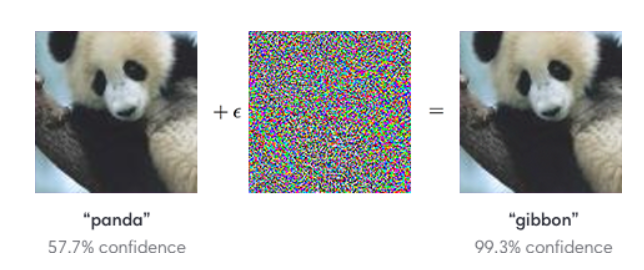




*To a human eye, these are both photos of a panda, but because of a small perturbation, the model misclassifies the second photo (which is the adversarial example) as a gibbon instead of a panda, with high confidence.*

**Evasion** is the act of attacking the model by constructing such adversarial examples from test images.

## <a id='2.1'></a> 2.1   How can we construct adversarial examples?

The most common way of finding perturbations to generate adversarial examples which can fool deep neural networks is by optimizing the inputs to maximize the prediction error. Below we will introduce **Fast Gradient Sign Method** and **Projected Gradient Descent**, two methods for finding such perturbations.

### <a id='2.1.1'></a> 2.1.1   Fast Gradient Sign Method (FGSM)

[Explaining and Harnessing Adversarial Examples](https://arxiv.org/pdf/1412.6572.pdf)  paper introduces a method for generating adversarial examples and also brings about a conjecture that the reason neural networks are vulnerable to adversarial examples is their linear nature. *(For more information, see section 4 of the paper.)*

Let $\textbf{x}$ be the model's input, $y$ the associated label, $\theta$ the parameters of the model, and $J(\theta, \textbf{x}, y)$ the loss function. We find the desired perturbation $\eta$ by maximizing $J(\theta, \textbf{x}+\eta, y)$ such that $||\eta||_{2}\le \epsilon$. In this way, the perturbation is assured to be small (with a maximum $L_2$ norm of $\epsilon$) and the model is likely to misclassify $\textbf{x}+\eta$, since it maximizes the loss. 

By linearizing the loss function around $\textbf{x}$, we obtain a solution of $\eta = \epsilon sign(\nabla_{x} J(\theta, \textbf{x}, y))$. To see why, consider the first order taylor expansion of $J(\theta, \textbf{x}+\eta, y) = J(\theta,\textbf{x}, y)+\nabla_{x} J(\theta, \textbf{x}, y) ^T \eta$. The first term ,$J(\theta,\textbf{x}, y)$, is constast with changing $\eta$. In order to maximize $\nabla_{x} J(\theta, \textbf{x}, y) ^T \eta$, $\eta$ should be in the direction of $sign(\nabla_{x} J(\theta, \textbf{x}, y))$. Since $||\eta||_{2}\le \epsilon$, the maximum norm $\eta$ can have is $\epsilon$. Therefore, $\nabla_{x} J(\theta, \textbf{x}, y) ^T \eta$ will be maximized at $\eta = \epsilon sign(\nabla_{x} J(\theta, \textbf{x}, y))$.

They called this method of generating adversarial examples the **Fast Gradient Sign Method**, or in short FGSM. Note that the required gradient can be computed efficiently using backpropagation, and since this method needs gradients, it can only be used when adversaries have **white-box** access to the model.

The FGSM attack in PyTorch [[4](https://adversarial-ml-tutorial.org/)] :

(Note that taking gradients of the loss function with respect to $\textbf{x}$ or $\eta$ yields same results.)

In [ ]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X """
    eta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + eta), y)
    loss.backward()
    return epsilon * eta.grad.detach().sign()

### <a id='2.1.2'></a> 2.1.2   Projected Gradient  Descent (PGD)

PGD simply repeats the updates in FGSM for several iterations and in every iteration, applies a projection function to keep the results within a reasonable distance from the initial input. In PGD there are two hyperparameters: $\alpha$ measures the step size we take in the direction of the gradient, and $\epsilon$ is the parameter of the projection function (e.g. the radius of the ball if we want to project on an $L_2$ ball). The pseudo-code for PGD is as follows:

<center>
Repeat for $t$ iterations:</center>
<center>
$
\delta:= \mathcal{P}(\delta+\alpha\nabla_{\delta} J(\theta, \textbf{x}, y))
$</center>

where $\mathcal{P}$ is a projection function (for example, clipping in case of $l_{\infty}$ norm), and the $\delta$ computed after $t$ iterations would be the perturbation used in generating the adversarial example.

PGD usually results in more efficient adversarial examples (i.e. higher attack success rates) than FGSM but has a higher computational overhead.



The PGD attack in PyTorch [[4](https://adversarial-ml-tutorial.org/)] :

In [ ]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

## <a id='2.2'></a> 2.2   Targeted and Non-targeted attacks

Adversarial attacks fall into two categories, *targeted* or *non-targeted*. Suppose we have a classifier with loss function $l$, parameters $\theta$, and an input **$x$** with label $y$. A **targeted attack** aims to misclassify the input to a target class *t$\neq$y*, whereas a **non-targeted attack** only aims to misclassify the input into a class different from its natural one ($y$) [[6](https://www.oxford-man.ox.ac.uk/wp-content/uploads/2020/03/BayesOpt-attack-paper-002.pdf)], [[7](https://arxiv.org/pdf/1904.12843.pdf)].
 In mathematical terms, a targeted attack aims to solve the optimization problem (1), and a non-targeted attack aims to solve the optimization problem (2), where: 


<center>$(1):\ \ \max\limits_{\delta}\  l(x+\delta, y, \theta)\ \ s.t. ||\delta||_{p}\le \epsilon\ \ ,\ \ \ \ \ \ \ (2):\ \ \max\limits_{\delta}\  l(x+\delta, y, \theta)-l(x+\delta, t, \theta)\ \ s.t. ||\delta||_{p}\le \epsilon$</center>

where $\delta$ is the adversarial perturbation, $\epsilon$ is the perturbation budget, and $||.||_p$ is the $l_p$ norm.

## <a id='2.3'></a> 2.3   Universal Perturbations

[Universal Adversarial Perturbations](https://arxiv.org/pdf/1610.08401.pdf) paper shows the existence of a single but small perturbation, whose adding to natural images will result in misclassification of those images with high probability. They called such perturbations **universal** as they are image-agnostic. They also showed that such perturbations are not only universal across images but also generalize well across deep neural networks. This is called **transferability**, meaning that universal perturbations computed for a specific architecture (e.g., VGG-19) are also valid for another architecture (e.g., GoogLeNet). For example, universal perturbations computed for the VGG-19 have a fooling ratio of 53.6% on GoogLeNet, both on the ImageNet dataset. So the paper claims that these universal perturbations are doubly universal, both with respect to the data and the network architectures. You can see the algorithm for finding such perturbations in the paper (Algorithm 1). Moreover, for an explanation of the vulnerability to universal perturbations, you can look at **section 4** of the paper. 

## <a id='2.4'></a> 2.4   Adversarial Training: a defense against evasion

So far, we have talked about how to attack a model at test time and construct adversarial examples that would misclassify the model with a high probability. **Adversarial Training** is a mechanism to defend against these kinds of attacks and make the model **robust**. Adversarial Training is the process of training the model on adversarial examples with their true label, i.e. teaching the model not to get fooled by adversarial examples. When the model is trained in this way, it will classify an unseen adversarial example (generated to misclassify the model) correctly with a higher probability so it becomes robust against evasion. To obtain a better intuition on Adversarial Training and how it works, take a look at chapter 4 of [[4](https://adversarial-ml-tutorial.org/)], parts 1 and 2 (*From adversarial examples to training robust models* and  *Adversarial training with adversarial examples*).

# <a id='poisoning'></a> 3.   Poisoning attacks and defenses

Adversarial poisoning attacks distort the training data of a model in order to manipulate its behavior at test time. For example, an adversary adds poisoned examples to the training set to change the classification of the classifier on specific test instances. Three types of thread models are:

**General poisoning attacks**: In its general case, the attacker can make any distortion to the training set by adding or removing a limited number of training instances. Manipulating a training instance or changing its label can also be considered as removing the original instance and adding the poisoned one. The *attack magnitude* $\rho$ is defined as the *cardinality of the symmetric difference* between clean and poisoned training sets. [[10](https://arxiv.org/pdf/2006.14768.pdf)]

**Label-flipping poisoning attacks**: In this thread model, the attacker flips the label of a bounded number of training samples. The attack magnitude $\rho$ is defined as the number of label-flipped instances. [[10](https://arxiv.org/pdf/2006.14768.pdf)]

**Targeted clean-label poisoning attacks**: In section 3.1, we will dive into the paper [Poison Frogs! Targeted Clean-Label Poisoning
Attacks on Neural Networks](https://arxiv.org/pdf/1804.00792.pdf) to learn about these kinds of attacks in detail. 

## <a id='3.1'></a> 3.1   Targeted Clean-Label Poisoning Attacks on Neural Networks [[9](https://arxiv.org/pdf/1804.00792.pdf)]

First, let's see what Targeted Clean-Label poisoning attacks mean. 

**Clean-Label** means that the attacker does not have any control over the labeling process of training data;  the poisoned training data appear to be labeled correctly according to an expert observer. For example, an adversary might put poisoned images online and wait for them to be scraped by a bot that collects data from the web. It is important that in this kind of attack, the attacker does not have any inside access to the data collection/labeling process, which makes it **more realistic** than those in which the attacker has access to the labeling procedure.

**Targeted** means that the attacker aims to control the behavior of a classifier on specific test instances so the classifier would misclassify them. However, with this attack, the overall performance of the victim classifier on training data would not degrade noticeably, which makes this attack **hard to detect**. Moreover, the state-of-the-art poisoning defenses that measure the performance impact of training instances (such as [[11](https://people.eecs.berkeley.edu/~adj/publications/paper-files/SecML-MLJ2010.pdf)]) become ineffective.

### <a id='3.1.1'></a> 3.1.1 A simple clean-label poisoning attack

An attacker first chooses a **target instance** from the test set and a **base class** that is different from the target class. The goal of the attacker is to manipulate the classifier to misclassify the target instance into the base class at test time. The attacker samples a **base instance** from the base class and makes imperceptible changes to it to construct a **poison instance**. The model will then be trained on clean dataset + poison instances, and the attack is successful if the model labels the target instance as a base class instance at test time. Note that the target instance is chosen from the test set and is not seen by the model during the training procedure.

Now let's see the optimization procedure in which the poison instance is generated.

Take **$b$** as the base instance, **$t$** as the target instance, $f(x)$ as the *feature space representation* of $x$ (the representation of the input $x$ at the penultimate layer (before the softmax layer)), and $\beta$ as a hyperparameter. The poison instance **$p$** is found by solving the following optimization problem:


<center>$p = argmin_x ||f(x)-f(t)||_2^2 + \beta ||x-b||_2^2$</center>

The goal of this equation is to find a poison instance **$p$** that is close to the base instance **$b$** (hence will be labeled as the base class by a human labeler) whose representation ($f(x)$) is close to the representation of **$t$** ($f(t)$) in the feature space. If the model is trained on clean dataset + poisoned instances, then the decision boundary in feature space is expected to shape in a way that the model labels the poisoned instance **$p$** as if it was in the base class. Since the representation of the target **$t$** is close to the representation of $p$, then the decision boundary will probably include the target instance in the base class along with the poison instance, therefore **$t$** would be labeled as the base class.

The **algorithm** for solving this optimization problem is as follows:

<div>
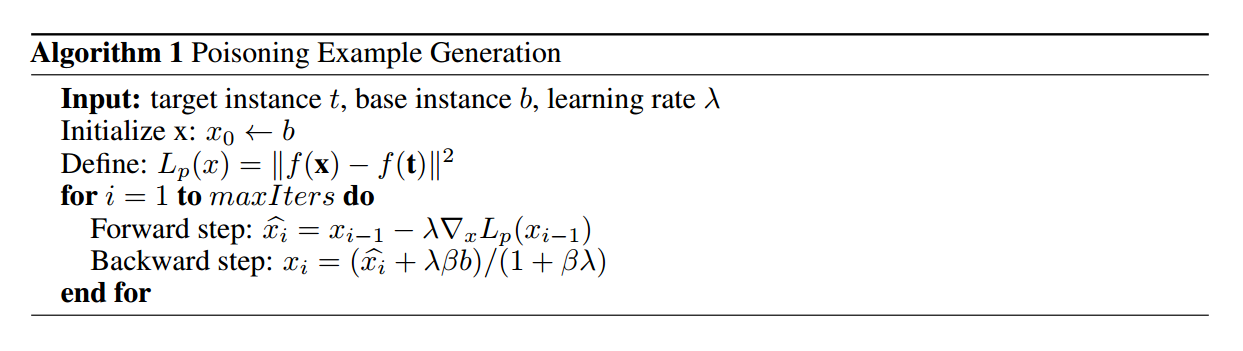
</div>

The forward step is a gradient descent update to minimize the $L_2$ distance to the target instance in the feature space. The backward step is a proximal update that minimizes the Frobenius distance from the base instance in the input space. $\beta$ is a hyperparameter that is tuned to make the poison instance look realistic in the input space, enough to fool an unsuspecting human observer into thinking the image has not been manipulated. Since the attacker has access to the gradients of the model, this is a **white-box** attack.

To see an **implementation** of this attack, take a look at [this notebook]().

### <a id ='3.1.2'></a> 3.1.2  Poisoning attacks on transfer learning vs. end-to-end training

The paper compares the effect of poisoning attacks in two scenarios: one is transfer learning, in which a pre-trained model is used and only the last layer (softmax layer) is trainable during training, and one is end-to-end training in which all layers of the model are trainable. Different behaviors can be seen in these two cases.

Let's first look at the comparison of decision boundary angular deviation:

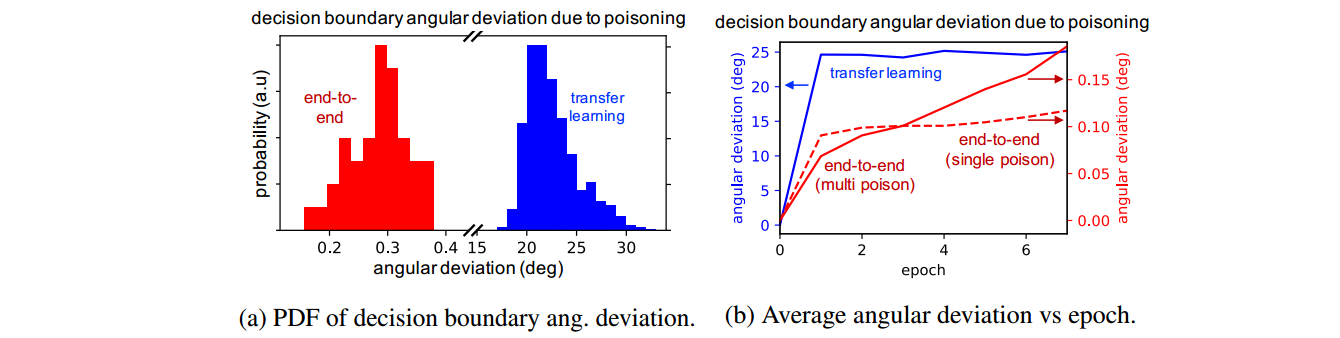

The **angular deviation** is the degree to which the decision boundary rotates after retraining on poisoned instances. As you can see, there is a huge gap between the angular deviation for transfer learning vs. end-to-end training. 

In the **transfer learning** scenario, since only the last layer is trainable, the model acts as a linear model. The intuition is that in this case, the decision boundary rotates to encompass the poisoned instance within the base class region, and as seen in the figure above, this deviation occurs mostly in the first epoch.

For a simplified example, look at the figure below. Here, blue and red samples are original instances, and the black line is the classifier after training on the clean dataset. The square green sample is a poison instance added to the training set with the aim to misclassify the target 𝑡. When the model is trained on clean dataset + poison instance, the classifier rotates to the green line and 𝛼 is the angular deviation. As a consequence, target 𝑡 will be classified as if it were in the red samples class.

<center>
    <div>
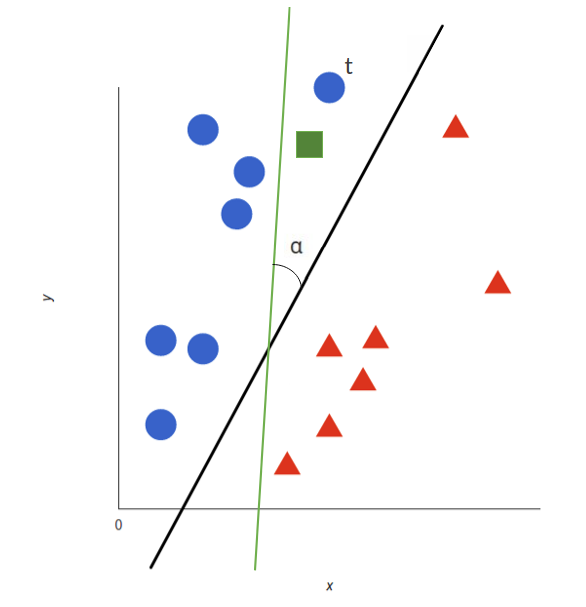
    </div>
</center>    

The training process on poisoned examples in the **end-to-end** scenario does not work in the same way. In the end-to-end setting where all layers are trainable, the attacks become more difficult and are not as effective as they are in the transfer learning case. However, using some tricks such as *watermarking* and *multiple poison instances*, poisoning attacks can still be effective, and actually, these tricks are necessary for the attack to be successful.

First, consider the case in which the model is trained with a single poison instance. Unlike the transfer learning scenario where the final layer decision boundary rotates to accommodate the poison instance within the base region, the decision boundary in the end-to-end training scenario is unchanged after retraining on poison instances, as shown by red bars in the angular deviation figure above. The intuition is that during retraining with the poisoned data, the network modifies its lower-level feature extraction kernels in the shallow layers in a way that the feature space position of the poison instance, which is labeled as a base, is returned to the base class distribution. So, it will not be close to the target representation in feature space anymore, and therefore, the target would not be misclassified at test time. For a successful attack, we need to find tricks that keep the target close to the poison instance in feature space after retraining. Two of these tricks are **watermarking** and **multiple poison instances**, and it turns out that both of them are required for the attack to be successful.

### Watermarking

Watermarking is a way to empower poisoning attacks by adding a low-opacity watermark of the target instance to the poison instance to prevent their separation in the feature space during retraining. The base instance is watermarked with target opacity $\gamma$ by taking the weighted average of base $b$ and target $t$: $\textbf{b} = \gamma.\textbf{t} + (1-\gamma).\textbf{b}$ and then used to generate a poison instance. By choosing a sufficiently small value for $\gamma$, the poison and base instances will be visually distinct. To see some examples, look at the images below. These are 12 out of 60 random poison instances that successfully cause a bird target instance to get misclassified as a dog in the end-to-end training scenario. An adversarial watermark (opacity 30%) of the target bird instance is applied to the base instances when making the poisons.



<div>
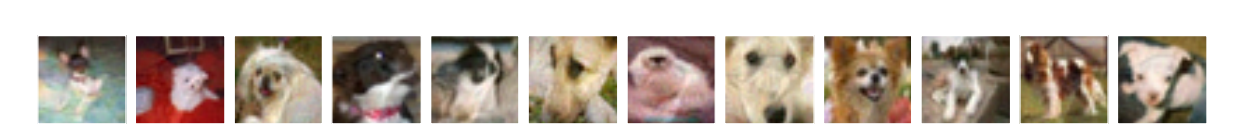
</div>

### Multiple poison instances

As mentioned earlier, poisoning attacks with one poison instance for each target in the end-to-end training scenario is difficult since the model learns feature embeddings that distinguish target and poison instances in the final feature space. However, for the classifier to resist multiple poison instances, it must learn feature embeddings that separate *all* poison instances from the target while ensuring that the target instance remains in the target region. The experiments in the paper show that using multiple poison instances generated from a high diversity of bases prevents the moderately-sized network from learning features of the target that are distinct from those of the bases. Therefore, upon retraining, the target is pulled along with the poison instances to the base distribution, resulting in a successful attack. For a visual understanding of what happens, look at the figure below.

<center>
    <div>
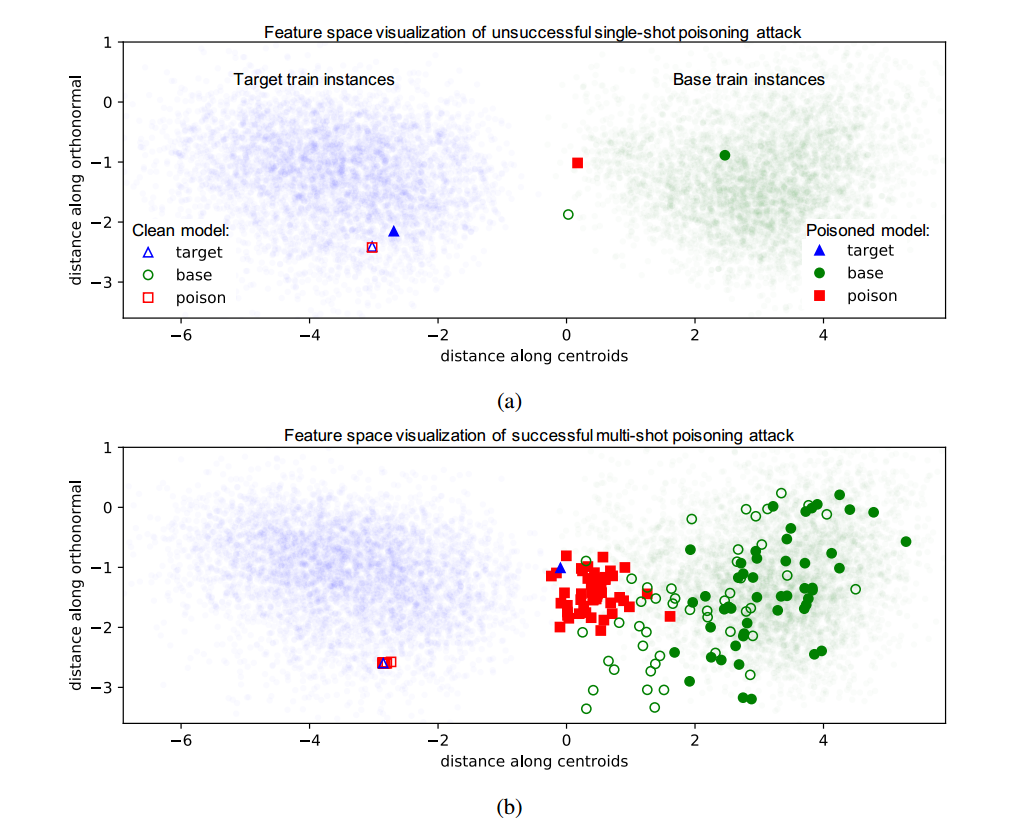
    </div>
</center>

*To sum up, during retraining in the transfer learning setting, the decision boundary rotates to encompass the target instance in the base region (resulting in high angular deviation), while in the end-to-end setting the model pulls the target instance into the base distribution in feature space.*

## <a id='3.2'></a> 3.2 A certified defense against poisoning attacks

[Deep Partition Aggregation: Provable Defense against General Poisoning Attacks](https://arxiv.org/pdf/2006.14768.pdf) introduces a certified defense called **DPA** against general poisoning attacks and a  modified version of it called **SS-DPA** (semi-supervised DPA) for label-flipping attacks.

A certified defense gives a *certificate $\rho$* for each test instance $t$, which guarantees the model will classify $t$ correctly if the distortion to the training set (for example, the number of instances whose labels are flipped) is less than or equal to $\rho$. In other words, it provides a lower bound on the attack magnitude required to manipulate the model to misclassify $t$.

### <a id='3.2.1'></a> 3.2.1 Deep Partitioning Aggregation (DPA)

DPA is a certified **defense against general poisoning attacks** (introduced in [section 3](#poisoning)) based on **ensemble learning**. In this method, we keep *$k$* base classifiers (which could be neural networks) and partition the training set into *$k$* subsets using a deterministic hash function *$h$*, and then train the classifier *$i$* on the subset $i$. The hash function must be *deterministic* such that the hash value depends only on the value of the training instance $s$ itself (for example, for an image $I$, $h(I)$ can be defined as the sum of its pixels ($h(I)=\Sigma_{i,j} I_{i,j})$), so that poisoning other samples, or changing the order of data do not change the partition that $s$ is assigned to; therefore, in all these alterations $s$ will be used to train the same base classifier. At test time, the test instance $t$ is passed to all of the classifiers and the label which has the majority of votes will be the chosen label for $t$. 

How does this help to defend against poisoning attacks? With this architecture and setting, adding a new (probably poisoned) training instance, or removing one, will affect the classification of only one classifier. This lets us provide certificates for each test instance.

Let us proceed with an example: Consider $k=10$ and classification with $3$ classes. Suppose that by training on clean data, the number of classifiers which output $i=1,2,3$ for test instance $t$ is $6,3,1$ respectively. With one insertion or deletion, in the worst case, the numbers will change to $5,4,1$, so class $1$ still has the majority of votes, and therefore, the result of the network for instance $t$ will not change with one alteration. In the general case, let $n_1$ be the number of base classifiers that output $c$ as the final label for the test instance $t$, and let $n_2$ be the number of base classifiers that output the next-most-frequently returned class $c^\prime$. With the floor of $\frac{n_1-n_2}{2}$ alterations, $c_1$ will still be the highest voted class. So $\frac{n_1-n_2}{2}$ is a lower bound on the alterations (e.g. the symmetric difference between the clean and poisoned dataset) needed to manipulate the classification of the model on instance $t$.

There are also some *practical considerations* that we should take care of. The whole function that computes the label and the training procedure should be deterministic. As we mentioned earlier, the hash function should be deterministic (i.e. only based on the value of the training sample). Also, the output of a base classifier should be a deterministic function of its training data as an unordered set. To ensure this, the training data for each classifier should be sorted before training, and we should set a fixed random seed for each classifier at the start of training to make the training procedure, which is based on standard stochastic gradient descent, deterministic. 

For a mathematical formulation of DPA and its main theorem, and to see why such a deterministic function is required, look at sections 3.1 and 3.2 of the paper.

### <a id='3.2.2'></a> 3.2.2 Semi-Supervised Deep Partition Aggregation (SS-DPA)

SS-DPA is a **defense against label-flipping attacks** (introduced in [section 3](#poisoning)). Since in these attacks the *unlabeled* dataset is *clean*, we can trust them and use semi-supervised algorithms to learn more complex features from the unlabeled dataset and empower the base classifiers. Similar to DPA, we can ensure that a particular (unlabeled) sample is assigned to the same partition regardless of the label so that only one partition is affected by a label flip. Certificates provided by this method are usually larger than those for general poisoning attacks. In the method proposed in the paper, they choose a semi-supervised algorithm where the unlabeled training dataset is used *only once*, before the training on labeled data, to learn semantic feature representations of data, and then these learned features are shared with base classifiers when training on labeled data.

### Results

Look at the figure below for the results of the algorithms:

<div>
<img src="attachment:cert.png" width="750"/>
</div>

<div>
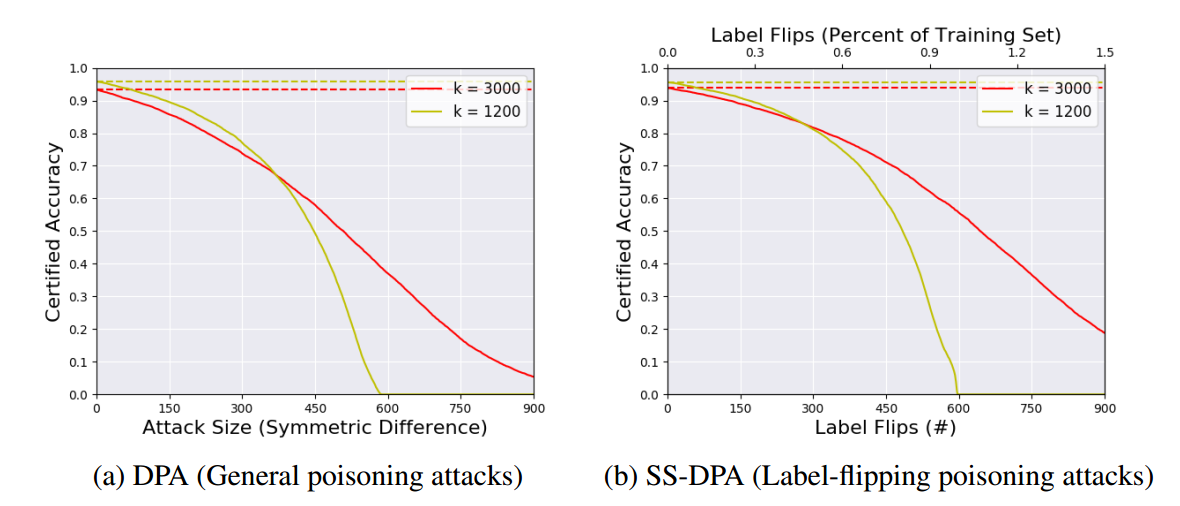
</div>

The metric used here, **certified accuracy**, as a function of the attack magnitude (symmetric-difference or label-flips), refers to the fraction of test instances that are both correctly classified and are certified as robust to attacks of that magnitude. According to the figure above, with the symmetric difference of 450 between clean and poison datasets (for example, insertion of 450 poison instances), about 50% of the training dataset will be classified correctly and are robust to this attack magnitude. This fraction, however, is higher with about 10% for 450 label flips.



# <a id='4'></a> 4. References

1. <a id='ref_8'></a> **[Security and Privacy in Machine Learning course](http://ce.sharif.edu/courses/99-00/1/ce875-1/)**, Mohammad Hossein Rohban, Amir Mahdi Sadeghzadeh, Fall 2020


2. <a id='ref_2'></a> Christian Szegedy, Wojciech Zaremba, Ilya Sutskever, JoanBruna, Dumitru Erhan, IanGoodfellow, and Rob Fergus, **[Intriguing properties of neural networks](https://arxiv.org/pdf/1312.6199.pdf)**, 2013


3. <a id='ref_3'></a> Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy, **[Explaining and Harnessing Adversarial Examples](https://arxiv.org/pdf/1412.6572.pdf)**, 2015 


4. <a id='ref_4'></a> A tutorial on **[Adversarial Robustness, Theory and Practice](https://adversarial-ml-tutorial.org/)**


5. <a id='ref_5'></a>  Seyed-Mohsen Moosavi-Dezfooli, Alhussein Fawzi, Omar Fawzi, and Pascal Frossard,  **[Universal Adversarial Perturbations](https://arxiv.org/pdf/1610.08401.pdf)**, 2016


6. <a id='ref_6'></a> Binxin Ru, Adam D. Cobb, Arno Blaas, Yarin Gal, **[BayesOpt Adversarial Attack](https://www.oxford-man.ox.ac.uk/wp-content/uploads/2020/03/BayesOpt-attack-paper-002.pdf)**, ICLR 2020


7. <a id='ref_7'></a> Ali Shafahi et. al, **[Adversarial Training For Free!](https://arxiv.org/pdf/1904.12843.pdf)**, NIPS 2019


8. <a id='ref_1'></a> Nicolas Papernot et. al, **[SoK: Towards the Science of Security and Privacy in Machine Learning](https://arxiv.org/pdf/1611.03814.pdf)**, 2016


9. <a id='ref_9'></a>  Ali Shafahi et. al, **[Poison Frogs! Targeted Clean-Label Poisoning Attacks on Neural Networks](https://arxiv.org/pdf/1804.00792.pdf)**, 2018


10. <a id='ref_10'></a> Alexander Levine, Soheil Feizi, **[Deep Partition Aggregation: Provable Defense against General Poisoning Attacks](https://arxiv.org/pdf/2006.14768.pdf)**, 2021


11. <a id='ref_11'></a> Marco Barreno et, al, **[The security of machine learning](https://people.eecs.berkeley.edu/~adj/publications/paper-files/SecML-MLJ2010.pdf)**, 2010

